# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 20000 # Example number of data points
iterations_exp_initial = 1000 # Iterations for initial training phase
iterations_exp_long = 30000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
#eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(x_points): # x_points is N x dim
    """
    Computes the target function psi(x) = ||x||_2^2 for the given problem.
    """
    return euclid_norm_sq(x_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)



def evaluate_learned_J_HJ_approx(x_points, model):
    """
    Evaluates the learned prior J(x) using the method of characteristics
    for quadratic Hamiltonian H(p) = 0.5 * ||p||^2.
    
    The method of characteristics gives us:
    J(grad_psi(x)) = <x, grad_psi(x)> - 0.5 * ||grad_psi(x)||^2 - psi(x)
    
    To get J(x), we need to find the x' such that grad_psi(x') = x,
    then evaluate the formula at x'.
    
    For this specific problem where psi(x) = ||x||^2, we have grad_psi(x) = 2x,
    so to evaluate J(y), we need x = y/2.
    
    Args:
        x_points: numpy array of shape (N, dim) containing evaluation points
        model: trained LPN model
    
    Returns:
        J_est: numpy array of shape (N,) containing estimated J values
    """
    # To evaluate J(x), we need to find x' such that grad_psi(x') = x
    # For the learned psi approximating ||x||^2, grad_psi(x) ≈ 2x
    # So x' ≈ x/2 to get grad_psi(x') ≈ x
    
    # However, for a general learned model, we'd need to solve the inverse problem
    # For simplicity, assuming the model learned psi(x) ≈ ||x||^2 well,
    # we use the approximation x' = x/2
    
    x_prime = x_points / 2.0
    
    # Convert to tensor
    x_tensor = torch.from_numpy(x_prime).float().to(device)
    x_tensor.requires_grad_(True)
    
    # Get psi(x')
    psi_x = model.scalar(x_tensor)
    
    # Get gradient of psi at x'
    grad_psi = model(x_tensor)
    
    # Compute inner product <x', grad_psi(x')>
    inner_prod = torch.sum(x_tensor * grad_psi, dim=1, keepdim=True)
    
    # Compute ||grad_psi(x')||^2
    grad_psi_norm_sq = torch.sum(grad_psi * grad_psi, dim=1, keepdim=True)
    
    # Apply the formula: this gives J(grad_psi(x')) ≈ J(x)
    J_est = inner_prod - 0.5 * grad_psi_norm_sq - psi_x
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_psi_true = x1_0_psi_true
        x2_0_J_true = x1_0_J_true

    x1_0_psi_est = cvx(x1_0_points, model)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"$\psi(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$\psi(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ for $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"$\psi(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$\psi(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned J)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, Concave Prior")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned J)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, Concave Prior")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)


In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
x_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(x_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

x_j_exp_tensor = torch.from_numpy(x_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: x_j_exp_tensor shape {x_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")


--- Generating Training Data for Concave Quadratic Prior ---
Generated training data: x_j_exp_tensor shape torch.Size([20000, 32]), psi_samples_exp_tensor shape torch.Size([20000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad, optimizer_concave_quad, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 29810.447265625
iteration 500 loss 384.4600524902344
iteration 0 loss 237.66201782226562
iteration 500 loss 159.34564208984375
iteration 1000 loss 122.76360321044922
iteration 1500 loss 107.6524658203125
iteration 2000 loss 99.60787963867188
iteration 2500 loss 91.98417663574219
iteration 3000 loss 83.08726501464844
iteration 3500 loss 72.64185333251953
iteration 4000 loss 60.71217346191406
iteration 4500 loss 47.79012680053711
iteration 5000 loss 35.24106216430664
iteration 5500 loss 25.146024703979492
iteration 6000 loss 18.359596252441406
iteration 6500 loss 13.82119369506836
iteration 7000 loss 10.600533485412598
iteration 7500 loss 8.179428100585938
iteration 8000 loss 6.329466342926025
iteration 8500 loss 5.003995895385742
iteration 9000 loss 4.0670552253723145
iteration 9500 loss 3.371464729309082
iteration 10000 loss 2.8252034187316895
iteration 10500 loss 2.3983407020568848
iteration 11000 loss 2.

L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---


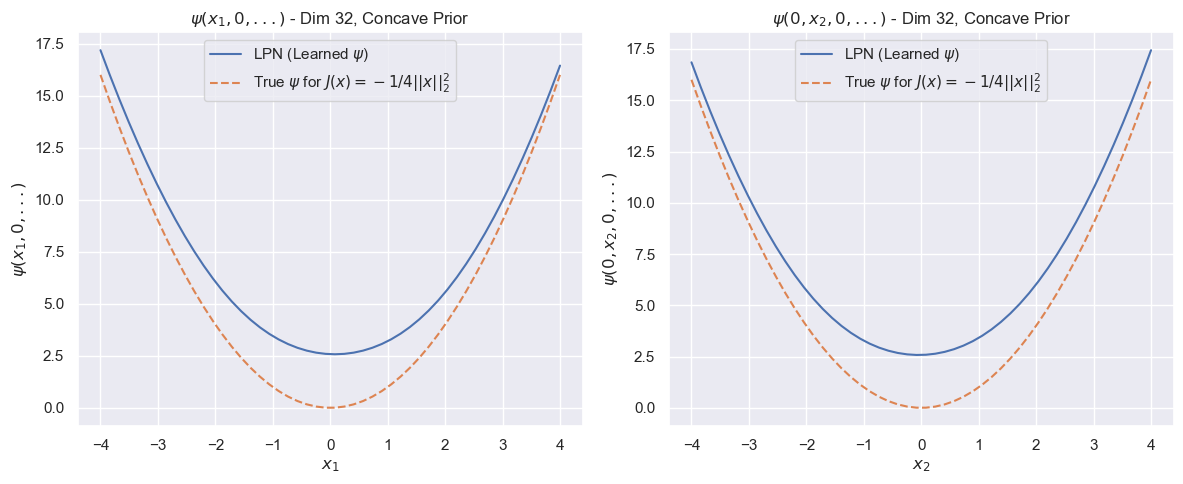

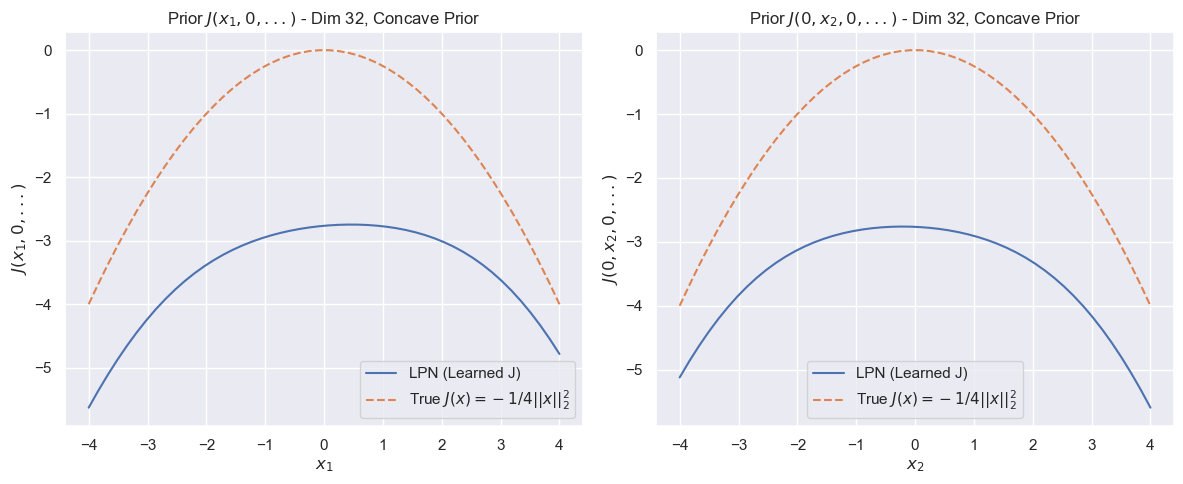

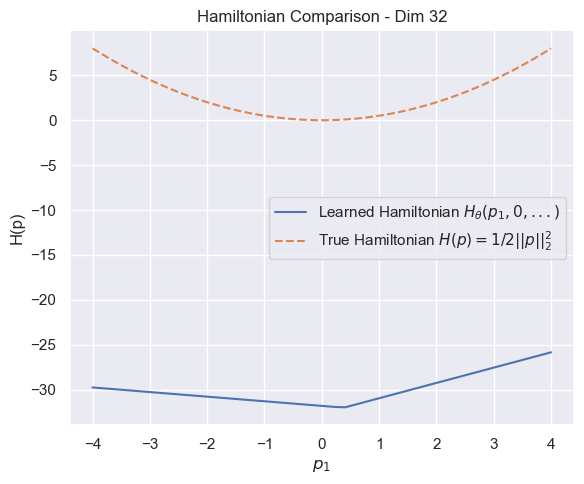

In [8]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad, a_exp, spacing, INVERT_MODE, dim_exp)
evaluate_learned_H(lpn_model_concave_quad, a_exp, spacing, dim_exp)

L1 loss -- Train

In [9]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l1 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad_l1 = torch.optim.Adam(lpn_model_concave_quad_l1.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1000):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad_l1.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l1, optimizer_concave_quad_l1, x_j_exp_tensor, psi_samples_exp_tensor, loss_type=1, gamma_loss=None)

torch.save(lpn_model_concave_quad_l1.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l1.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---
iteration 0 loss 170.72314453125
iteration 500 loss 13.406835556030273
iteration 0 loss 9.23701000213623
iteration 500 loss 7.694528102874756
iteration 1000 loss 6.748159408569336
iteration 1500 loss 5.630317211151123
iteration 2000 loss 4.456089019775391
iteration 2500 loss 3.7008309364318848
iteration 3000 loss 3.2805354595184326
iteration 3500 loss 3.00898814201355
iteration 4000 loss 2.8104946613311768
iteration 4500 loss 2.6551897525787354
iteration 5000 loss 2.5267245769500732
iteration 5500 loss 2.419163465499878
iteration 6000 loss 2.324038028717041
iteration 6500 loss 2.239882707595825
iteration 7000 loss 2.160142660140991
iteration 7500 loss 2.0924007892608643
iteration 8000 loss 2.0293726921081543
iteration 8500 loss 1.9721709489822388
iteration 9000 loss 1.917138695716858
iteration 9500 loss 1.8681445121765137
iteration 10000 loss 1.8220958709716797
iteration 10500 loss 1.7764344215393066
iteration 11000 loss 1

L1 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---


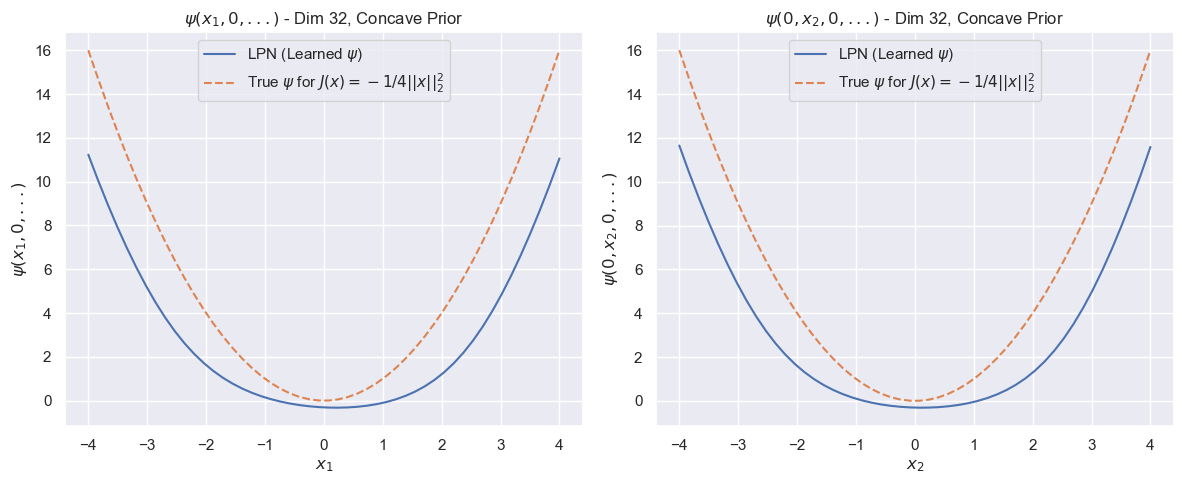

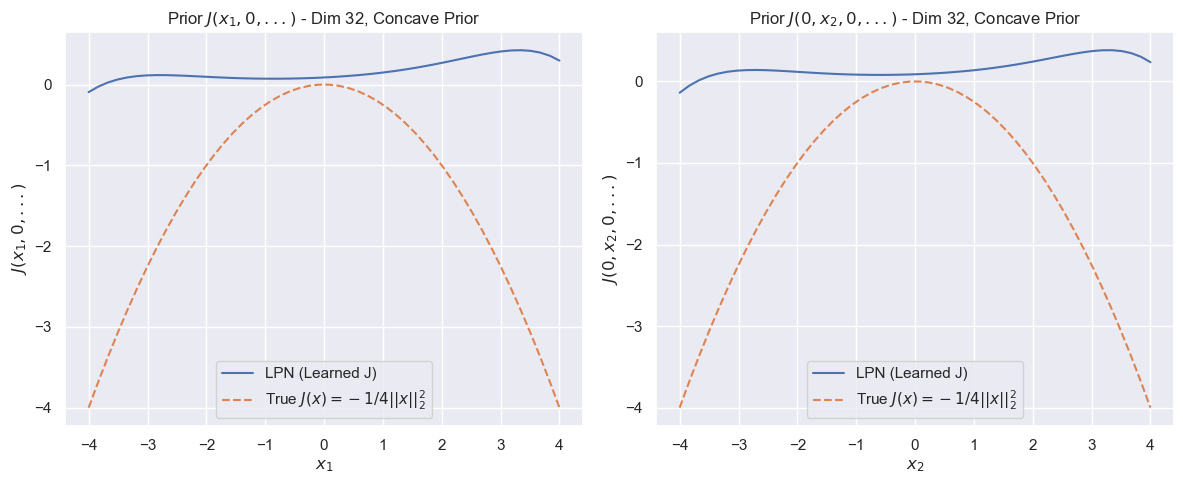

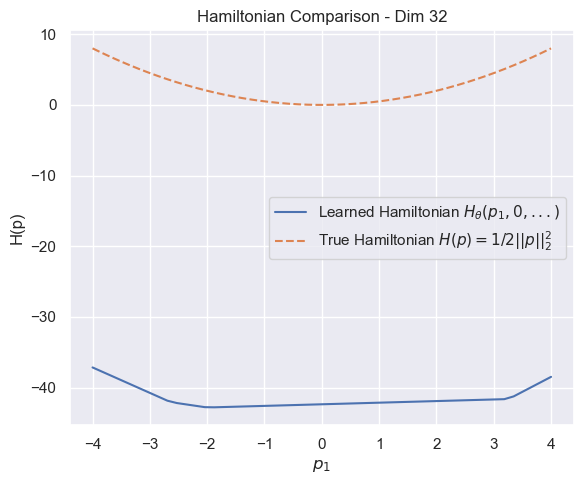

In [10]:
# --- Plot the results of the new experiment ---
plot_all_concave_quad(lpn_model_concave_quad_l1, a_exp, spacing, INVERT_MODE, dim_exp)
evaluate_learned_H(lpn_model_concave_quad_l1, a_exp, spacing, dim_exp)